In [10]:
import os
import sys,random
sys.setrecursionlimit(100000)
import matplotlib.pyplot as pyplot;
import time;
import networkx as nx
import pandas as pd
import pickle

Creating the Graph Class

In [11]:
class Graph :
    def __init__ (self) :
        self.edges = {}

    def add_edge (self, from_, to) :
        if from_ not in self.edges :
            self.edges[from_] = [to]
        else :
            self.edges[from_].append(to)

        if to not in self.edges :
            self.edges[to] = []

    def find_reachable_nodes (self, source_nodes) :
        # source nodes is a list of nodes
        reached = set([])
        for node in source_nodes :
            if node in self.edges :
                self.dfs (node, reached)

        return reached

    def dfs (self, node, reached) :
        for nbr in self.edges[node] :
            if nbr not in reached :
                reached.add (nbr)
                self.dfs (nbr, reached)

In [12]:
def load_graph(graph_path):
    print("load_graph")
    data = pd.read_csv(graph_path)
    print(data.head())
    edges = data.values.tolist()
    edges = [[int(edge[0]), int(edge[1])] for edge in edges]
    graph = nx.from_edgelist(edges)
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph

def loadFileForGraph(fileName) :
    f = open (fileName)
    lines = f.readlines()

    edges_list = []
    weight_list = []
    nodes_set = set([])
    for line in lines :
        
        if "node_1,node_2" in line  :
            print("inside loop")
            print(line)
            continue
        
        line=line.strip()
       
        node1, node2 = map(int, line.split(','))
        edges_list.append ([node1, node2])
        weight_list.append (random.random()/3)
        # weight_list.append (1)
        nodes_set.add(node1)
        nodes_set.add(node2)

    return edges_list, weight_list, nodes_set

def generateRamdomGraphs (num_graphs, edges, probs) :
    graph_snapshots = []
    for i in range (num_graphs) :
        tmp_graph = Graph ()
        for edge, prob in zip(edges, probs) : 
            rand = random.random()
            if rand < prob :
                tmp_graph.add_edge (edge[0], edge[1])
        graph_snapshots.append(tmp_graph)

    return graph_snapshots




(3)Given the initial set of active nodes A (all other nodes in the network are inactive),
a threshold is arbitrarily assigned to each node in the network. At time t, all
active nodes remain active at time t-1. And, when the sum of the influence of
the neighboring nodes of node v is greater than the threshold of node v at this
moment, node v is activated, that is, the condition that node v is activated is that
the cumulative effect of v-activated neighboring neighbors on v is greater than v.
The activation threshold is as follows:
X
w∈in(v),active(w)6=0
bwv ≥ θv


(4)After node v is activated, it will affect its neighbors at the next moment and repeat
the above process.
In the LT propagation model, the propagation process ends when the sum of the
influence of any of the active nodes already existing in the network cannot activate
their neighbor nodes that are in an inactive state

In [13]:
def getInfluenceMap(nodes,graphSnaps, threshold) :
    print("getInfluenceMap: ")
    influencedMap = {};
    for node in nodes:
        node_set = set();
        node_set.add(node);
        influencedMap[node] = findInfluence(node_set,graphSnaps,threshold);
    return influencedMap;

def findInfluence (nodes, graphSnaps, threshold) :
    influenced_node_count = {} # this contains nodes and count for each node
    for G in graphSnaps :
        S = G.find_reachable_nodes (nodes)
        # Update influenced_node_count looking at S
        for node in S :
            if node in influenced_node_count :
                influenced_node_count[node]+=1
            else :
                influenced_node_count[node] = 1

    influenced_nodes = set([])
    for node in influenced_node_count :
        if influenced_node_count [node] > threshold:
            influenced_nodes.add (node)

    # We do not want source nodes in the influenced set. Remove any nodes that are there in source nodes from influenced_nodes.
    for node in nodes :
        if node in influenced_nodes :
            influenced_nodes.remove (node)

    return influenced_nodes


#  LT Model Algorithm

In LT model, there can be serval nodes activating an inactive node at the same
time. If node u is active and wk is one of the nodes which is activating node u. So
node wk’s influence INFu(wk) can be measured as INFu(wk) = bwk,uθ−1

. If any node v, w in the Graph V satisfies bv,w > θw then set the equation bv,w = θw.


. If any node v, w in the Graph V satisfies bv,w > θw then set the equation bv,w = θw.
Then we can infer if we want to obtain the node v’s influence to u, we can get
it from combine the influence from v to wk andwk to u.



----------------------------------------------------------------
Input : G=(V,E),LT Model, seed set size K, float r
--------------------------------------------------------------------
Ouput : seed set S, the nodes count influenced by seed set
-----------------------------------------------------------------
1. Initial S, read graph G
2. for v in G, INF(v)=|Sigma(v)|T^-1
3. for i =1 to K do:
     select K nodes from given set S from the Network
     for v in S:
      INF(v)= sigma(v)T^-1
      T is the number of transmission
      select v=max{INF(v)}
      V=V-Z(v)
      S=S union V
    then Compute sigma(S)
    end for
 
4: return S,|sigma(S)|

Optimized Greedy Algorithm for LT Model



In [14]:
def heuristic1 (graph_snaps, nodes_set, k, step_size, threshold,influenceMap,selectedSet) :
    load_influence_map_from_file = 0
    # graph_snaps: graph snapshots
    # nodes_set: set of nodes in the complete graph
    # k: number of nodes to influence initially
    # step_size: number of nodes to add to the opt set every iteration
    uninfluencedNodes = nodes_set;


    bestNodes = set();
    maxLength = 0;
    maxNode = -1;
    for node in selectedSet:
        try:
            bestNodes = set.union(influenceMap[node],bestNodes);
        except:
            print("An exception occurred")
        bestNodes.add(node);
        uninfluencedNodes.discard(node);

        uninfluencedNodes = uninfluencedNodes.difference(bestNodes);


    if not load_influence_map_from_file :
        f = open ("influenceMapObject.pickle", "wb")
        pickle.dump (influenceMap, f)
        f.close ()
    else :
        f = open ("influenceMapObject.pickle", "rb")
        influenceMap = pickle.load (f)


    for uninfluenced_node in uninfluencedNodes:

        new_nodes_influenced = len(set.intersection(influenceMap[uninfluenced_node], uninfluencedNodes));
        if maxLength < new_nodes_influenced:
            maxLength = new_nodes_influenced;
            maxNode = uninfluenced_node;

        # print ("best nodes before", len(bestNodes))

    bestNodes.add(maxNode);
    try:
        bestNodes = set.union(bestNodes,influenceMap[maxNode]);
    except:
         print("An exception occurred")
    selectedSet.add(maxNode);

    # print ("uninfluenced nodes", len(uninfluencedNodes))

    return  bestNodes;

def main(filePath,selectedNodes,threshold,noOfRamdomGraph,pngFileName,plotNo,color,marker):
    print("GALAssignment",threshold)
    #graph=load_graph(filePath)
    #print(graph.edges)
    edgesDetails, weightProp, nodes =loadFileForGraph(filePath)
    graphSnaps = generateRamdomGraphs (noOfRamdomGraph, edgesDetails, weightProp)
    influencedMap=getInfluenceMap(nodes,graphSnaps,threshold)
    step_size=1
    ltModelSelectedSet = set()
    ltModelHeuristicTime = []
    ltModelHeuristic = []
    for k in selectedNodes:
        print ("k = ", k)

        if k == 0:
            continue;
        
        startTime = time.time();
        influenceSet = heuristic1(graphSnaps, nodes, k, step_size, threshold,influencedMap,ltModelSelectedSet);
        ltModelHeuristicTime.append(time.time() - startTime);
        ltModelHeuristicCount = len(influenceSet)
        ltModelHeuristic.append(ltModelHeuristicCount)
        #print(influenceSet)
        print("Size of influenced set is ", len(influenceSet));
        print("Selected set for LT MODEL is : ",ltModelSelectedSet)
    xi = list(sorted(selectedNodes))
    pyplot.subplot(plotNo)
    pyplot.plot(xi, ltModelHeuristicTime, color, label='Linear Thershold model', marker=marker,linestyle='--')
    pyplot.legend(loc='upper left')
    pyplot.ylabel('Total execution time');
    pyplot.xlabel('nodes selected');
    pyplot.draw()
    pyplot.savefig(pngFileName);

Get list of nodes that are max connectivity  to other nodes

In [15]:
def getNodesThatConnectMaxNodes(graph_path):
    print("load_graph")
    data = pd.read_csv(graph_path)
    print(data.columns)
    nodesConnectedToMorenetwork = data[['node_1','node_2']].groupby(['node_1'])['node_1'].size().nlargest(10).reset_index(name='top10')
    nodesConnectedToMoreNt = nodesConnectedToMorenetwork['node_1'].tolist()
    print(nodesConnectedToMoreNt)
    return nodesConnectedToMoreNt

#Strategie One 

Select n = 10 initial nodes to target initially. This is the initial set of active
nodes A0. For instance if the nodes selected are 1,6,7,10,21,22,32,34,40
and 80, then A0 = f1; 6; 7; 10; 21; 22; 32; 34; 40; 80g. Choose n = 10 nodes
according to the following two strategies and run your experimental
simulation.
{ Choose the top n highest degree nodes as the initial set A0 (degree
centrality)
{ Select the n top most in
uential nodes chosen according to another
node centrality measure, possible choices include betweenness cen-
trality, closeness centrality etc. Many of these are implemented in
libraries that support graph based analysis.

GALAssignment 10
inside loop
node_1,node_2

getInfluenceMap: 
k =  32
Size of influenced set is  190
Selected set for LT MODEL is :  {290}
k =  1
Size of influenced set is  328
Selected set for LT MODEL is :  {290, 524}
k =  34
Size of influenced set is  445
Selected set for LT MODEL is :  {112, 290, 524}
k =  6
Size of influenced set is  518
Selected set for LT MODEL is :  {112, 16, 290, 524}
k =  7
Size of influenced set is  588
Selected set for LT MODEL is :  {290, 524, 2510, 112, 16}
k =  40
Size of influenced set is  641
Selected set for LT MODEL is :  {290, 524, 2510, 112, 16, 1721}
k =  10
Size of influenced set is  689
Selected set for LT MODEL is :  {290, 524, 2510, 112, 16, 212, 1721}
k =  80
Size of influenced set is  728
Selected set for LT MODEL is :  {290, 524, 2510, 112, 16, 212, 1271, 1721}
k =  21
Size of influenced set is  766
Selected set for LT MODEL is :  {290, 524, 2510, 112, 16, 2160, 212, 1271, 1721}
k =  22
Size of influenced set is  801
Selected set for LT MOD

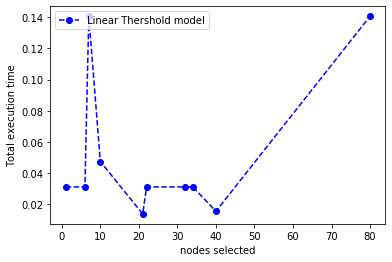

In [16]:
if __name__ == "__main__":
    filePath="lastfm_asia_edges.csv"
    selectedNodes={1,6,7,10,21,22,32,34,40,80}
    threshold=10
    noOfRamdomGraph=50
    pngFileName='LT_MODEL_GIVEN_NODES'
    plotNo=111
    color='-b'
    marker='o'
    main(filePath,selectedNodes,threshold,noOfRamdomGraph,pngFileName,plotNo,color,marker)
    

#Strategie two

Selection of initial nodes
A crucial aspect in the simulation is the choice of initial nodes. For an appli-
cation such as targeted marketing run on a social network graph, the aim is to
identify a small set of "in
uential" nodes to be targeted such that the informa-
tion spreads to as many other nodes as quickly as possible. On the other hand,
in applications such as epidemiological modeling of disease spread, the motiva-
tion is to identify "in
uential nodes" to target for interventional treatment such
as vaccinations.

load_graph
Index(['node_1', 'node_2'], dtype='object')
[524, 290, 2510, 3530, 3450, 110, 763, 1937, 1005, 4785]
GALAssignment 10
inside loop
node_1,node_2

getInfluenceMap: 
k =  290
Size of influenced set is  197
Selected set for LT MODEL is :  {290}
k =  3530
Size of influenced set is  351
Selected set for LT MODEL is :  {290, 524}
k =  524
Size of influenced set is  468
Selected set for LT MODEL is :  {112, 290, 524}
k =  1005
Size of influenced set is  570
Selected set for LT MODEL is :  {112, 16, 290, 524}
k =  2510
Size of influenced set is  650
Selected set for LT MODEL is :  {1665, 290, 524, 112, 16}
k =  110
Size of influenced set is  705
Selected set for LT MODEL is :  {1665, 290, 524, 112, 16, 212}
k =  1937
Size of influenced set is  752
Selected set for LT MODEL is :  {1792, 1665, 290, 524, 112, 16, 212}
k =  4785
Size of influenced set is  789
Selected set for LT MODEL is :  {1792, 1665, 290, 524, 112, 16, 2160, 212}
k =  3450
Size of influenced set is  826
Selected set f

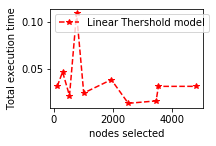

In [17]:
if __name__ == "__main__":
    filePath="lastfm_asia_edges.csv"
    selectedNodes=set(getNodesThatConnectMaxNodes(filePath))
    threshold=10
    noOfRamdomGraph=50
    pngFileName='LT_MODEL_MAX_CONNECTED_NODES'
    plotNo=222
    color='-r'
    marker='*'
    main(filePath,selectedNodes,threshold,noOfRamdomGraph,pngFileName,plotNo,color,marker)